In [2]:
import torch
from torch.functional import F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import copy
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from sad_nns.uncertainty import *
from neurops import *

**NORTH:** Define a LeNet-style model. 

Use the `ModSequential` class to wrap the `ModConv2d` and `ModLinear` model, which allows us to mask, prune, and grow the model. 

Use the `track_activations` and `track_auxiliary_gradients` arguments to enable the tracking of activations and auxiliary gradients later. 

By adding the `input_shape` of the data, we can compute the conversion factor of how many input neurons to add to the first linear layer when a new output channel is added to the final convolutional layer. 

In [4]:
# set seed
torch.manual_seed(0)

In [5]:
model = ModSequential(
        ModConv2d(in_channels=1, out_channels=8, kernel_size=7, masked=True, padding=1, learnable_mask=True),
        ModConv2d(in_channels=8, out_channels=16, kernel_size=7, masked=True, padding=1, prebatchnorm=True, learnable_mask=True),
        ModConv2d(in_channels=16, out_channels=16, kernel_size=5, masked=True, prebatchnorm=True, learnable_mask=True),
        ModLinear(64, 32, masked=True, prebatchnorm=True, learnable_mask=True),
        ModLinear(32, 10, masked=True, prebatchnorm=True, nonlinearity=""),
        track_activations=True,
        track_auxiliary_gradients=True,
        input_shape = (1, 14, 14)
    ).to(device)
torch.compile(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Add EDL Loss Function
# KLDivergenceLoss, MaximumLikelihoodLoss, CrossEntropyBayesRisk, SquaredErrorBayesRisk
criterion = SquaredErrorBayesRisk()
kl_divergence = KLDivergenceLoss()

**NORTH:** Get a dataset and define standard training and testing functions.

In [6]:
dataset = datasets.MNIST('../data', train=True, download=True,
                     transform=transforms.Compose([ 
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                            transforms.Resize((14,14))
                        ]))
train_set, val_set = torch.utils.data.random_split(dataset, lengths=[int(0.9*len(dataset)), int(0.1*len(dataset))])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                            transforms.Resize((14,14))
                        ])),
    batch_size=128, shuffle=True)

def train(model, train_loader, optimizer, criterion, epochs=10, num_classes=10, val_loader=None, verbose=True, plot=False, return_vals=False):
    model.train()

    train_acc_vals = []
    train_u_vals = []
    test_acc_vals = []
    test_u_vals = []

    for epoch in range(epochs):
        correct = 0
        for batch_idx, (data, target) in enumerate(train_loader):

            data, target = data.to(device), target.to(device)
            one_hot_target = F.one_hot(target, num_classes=num_classes)
            optimizer.zero_grad()
            output = model(data)
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # calculate uncertainty
            evidence = F.relu(output)
            alpha = evidence + 1
            u = num_classes / torch.sum(alpha, dim=1, keepdim=True)

            loss = criterion(evidence, one_hot_target)

            # calculate KL Divergence
            kl_div_loss = kl_divergence(evidence, one_hot_target)
            annealing_step = 10
            annealing_coef = torch.min(
                torch.tensor(1.0, dtype=torch.float32),
                torch.tensor(epoch / annealing_step, dtype=torch.float32),
            )
            
            loss = loss + annealing_coef * kl_div_loss

            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0 and verbose:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tUncertainty: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item(), u.mean()))
                
        train_acc, train_u = correct / len(train_loader.dataset), u.mean().detach().numpy().item()
        train_acc_vals.append(train_acc)
        train_u_vals.append(train_u)
        
        if val_loader is not None:
            print("Validation: ", end = "")
            test_acc, test_u = test(model, val_loader, criterion, return_vals=True)
            test_acc_vals.append(test_acc)
            test_u_vals.append(test_u)

    if plot:
        # Plotting the lines
        plt.plot(np.arange(epochs), train_acc_vals, label='Training Accuracy', color='blue')
        plt.plot(np.arange(epochs), train_u_vals, label='Training Uncertainty', color='purple')
        plt.plot(np.arange(epochs), test_acc_vals, label='Testing Accuracy', color='orange')
        plt.plot(np.arange(epochs), test_u_vals, label='Testing Uncertainty', color='red')
        plt.xticks(np.arange(0, epochs, 1))

        # Adding titles and labels
        plt.title('Accuracy vs. Uncertainty')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()

        # Show the plot
        plt.show()
    elif return_vals:
        return train_acc, train_u, test_acc, test_u

def test(model, test_loader, criterion, num_classes=10, return_vals=False):
    model.eval()
    test_loss = 0
    correct = 0
    uncertainties = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            one_hot_target = F.one_hot(target, num_classes=num_classes)
            output = model(data)

            evidence = F.relu(output)
            alpha = evidence + 1
            u = num_classes / torch.sum(alpha, dim=1, keepdim=True)
            uncertainties.append(u.mean())

            # test_loss += criterion(output, target).item() # sum up batch loss
            test_loss += criterion(output, one_hot_target).item()
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    avg_u = np.mean(uncertainties)
    
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%), Average Uncertainty: {:.4f}'.format(test_loss, correct, len(test_loader.dataset),
        accuracy, avg_u))
    
    if return_vals:
        return accuracy / 100, avg_u

**NORTH:** Pretrain the model before changing the architecture

/home/gottlijd/senior-research/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Epoch: 0 [0/54000 (0%)]	Loss: 0.981221	Uncertainty: 0.845094
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.861000	Uncertainty: 0.812008
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.830189	Uncertainty: 0.790378
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.784861	Uncertainty: 0.769037
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.762360	Uncertainty: 0.757058
Validation: Average loss: 0.0052, Accuracy: 4795/6000 (79.92%), Average Uncertainty: 0.7474
Train Epoch: 1 [0/54000 (0%)]	Loss: 0.784085	Uncertainty: 0.744701
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.640786	Uncertainty: 0.622684
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.444347	Uncertainty: 0.550568
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.335802	Uncertainty: 0.464248
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.359896	Uncertainty: 0.409669
Validation: Average loss: 0.0164, Accuracy: 5375/6000 (89.58%), Average Uncertainty: 0.3959


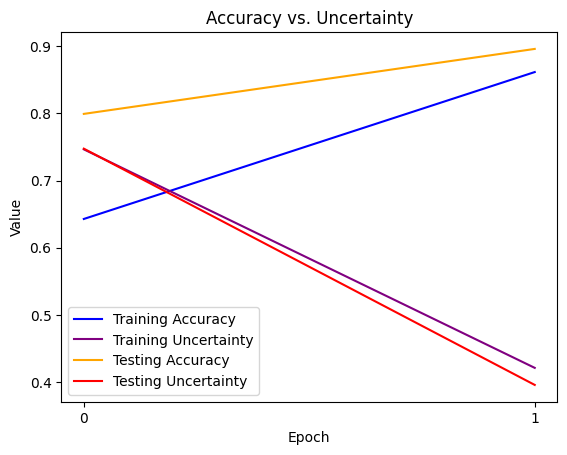

In [8]:
train(model, train_loader, optimizer, criterion, epochs=2, val_loader=val_loader, plot=True)

/home/gottlijd/senior-research/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Average loss: 0.0136, Accuracy: 5414/6000 (90.23%), Average Uncertainty: 0.3926
Train Epoch: 0 [0/54000 (0%)]	Loss: 0.726496	Uncertainty: 0.748009
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.682183	Uncertainty: 0.723842
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.652617	Uncertainty: 0.710171
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.642586	Uncertainty: 0.697965
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.617621	Uncertainty: 0.687874
Validation: Average loss: 0.0037, Accuracy: 5422/6000 (90.37%), Average Uncertainty: 0.6883
Train Epoch: 1 [0/54000 (0%)]	Loss: 0.623869	Uncertainty: 0.684042
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.489922	Uncertainty: 0.563655
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.364271	Uncertainty: 0.492041
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.337813	Uncertainty: 0.451672
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.303186	Uncertainty: 0.399695
Validation: Average loss: 0.0079, Accuracy: 5496/6000 (91.60%), Average Uncertainty: 0.4142
Train Epoch: 2 [0/54000 (0

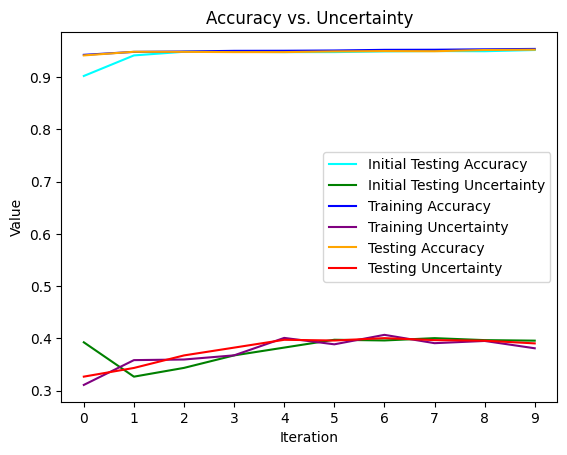

In [24]:
iterations = 10
modded_model = copy.deepcopy(model)
modded_optimizer = torch.optim.SGD(modded_model.parameters(), lr=0.01)
modded_optimizer.load_state_dict(optimizer.state_dict())

init_test_acc_vals = []
init_test_u_vals = []
train_acc_vals = []
train_u_vals = []
test_acc_vals = []
test_u_vals = []

for iter in range(iterations):
    init_test_acc, init_test_u = test(modded_model, val_loader, criterion, return_vals=True)
    train_acc, train_u, test_acc, test_u = train(modded_model, train_loader, modded_optimizer, criterion, epochs=5, val_loader=val_loader, return_vals=True)

    init_test_acc_vals.append(init_test_acc)
    init_test_u_vals.append(init_test_u)
    train_acc_vals.append(train_acc)
    train_u_vals.append(train_u)
    test_acc_vals.append(test_acc)
    test_u_vals.append(test_u)

# Plotting the lines
plt.plot(np.arange(iterations), init_test_acc_vals, label='Initial Testing Accuracy', color='cyan')
plt.plot(np.arange(iterations), init_test_u_vals, label='Initial Testing Uncertainty', color='green')
plt.plot(np.arange(iterations), train_acc_vals, label='Training Accuracy', color='blue')
plt.plot(np.arange(iterations), train_u_vals, label='Training Uncertainty', color='purple')
plt.plot(np.arange(iterations), test_acc_vals, label='Testing Accuracy', color='orange')
plt.plot(np.arange(iterations), test_u_vals, label='Testing Uncertainty', color='red')
plt.xticks(np.arange(0, iterations, 1))

# Adding titles and labels
plt.title('Accuracy vs. Uncertainty')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

### **NORTH:** Model Optimization Techniques

**NORTH:** Use a heuristic from `metrics.py` to measure the existing channels and neurons to determine which ones to prune.

The simplest one is measuring the norm of incoming weights to a neuron. We'll copy the model (so we have access to the original), then score each neuron and prune the lowest scoring ones within each layer. After running the following block, try uncommenting different lines to see how different metrics affect the model.

In [52]:
# iterations = 4
# modded_model = copy.deepcopy(model)
# modded_optimizer = torch.optim.SGD(modded_model.parameters(), lr=0.01)
# modded_optimizer.load_state_dict(optimizer.state_dict())

# for iter in range(iterations):
#     print(iter)
#     print('-----------------------------------------')
#     print(f'# activation layers: {len(modded_model.activations)}')
#     print(modded_model.parameter_count())
#     for layer in range(len(modded_model.activations)):
#         print(modded_model.activations[str(layer)].shape)
        
#     print('-----------------------------------------')

#     scores = weight_sum(modded_model[iter].weight)
#     to_prune = np.argsort(scores.detach().cpu().numpy())[:int(0.25*len(scores))]
#     print(to_prune)
#     modded_model.prune(iter, to_prune, optimizer=modded_optimizer, clear_activations=True)
#     init_test_acc, init_test_u = test(modded_model, val_loader, criterion, return_vals=True)
#     train_acc, train_u, test_acc, test_u = train(modded_model, train_loader, modded_optimizer, criterion, epochs=1, val_loader=val_loader, return_vals=True)

    
# print('-----------------------------------------')
# print(f'Final # activation layers: {len(modded_model.activations)}')
# print(modded_model.parameter_count())
# for layer in range(len(modded_model.activations)):
#     print(modded_model.activations[str(layer)].shape)
# print('-----------------------------------------')

0
-----------------------------------------
# activation layers: 6
15754
torch.Size([16, 8, 10, 10])
torch.Size([32, 16, 6, 6])
torch.Size([32, 16, 2, 2])
torch.Size([64, 32])
torch.Size([20, 10])
torch.Size([0])
-----------------------------------------
[1 2]
Average loss: -0.0053, Accuracy: 5504/6000 (91.73%), Average Uncertainty: 0.4562
Train Epoch: 0 [0/54000 (0%)]	Loss: 0.490965	Uncertainty: 0.584366
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.467446	Uncertainty: 0.579750
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.444877	Uncertainty: 0.573134
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.426415	Uncertainty: 0.571329


KeyboardInterrupt: 

Average loss: 0.0134, Accuracy: 4946/6000 (82.43%), Average Uncertainty: 0.5130
Validation: Average loss: 0.0025, Accuracy: 5574/6000 (92.90%), Average Uncertainty: 0.5608
Total Effective Parameters: 15754
Average loss: 0.0033, Accuracy: 5277/6000 (87.95%), Average Uncertainty: 0.5874
Validation: Average loss: 0.0023, Accuracy: 5601/6000 (93.35%), Average Uncertainty: 0.5399
Total Effective Parameters: 15754
Average loss: 0.0031, Accuracy: 5404/6000 (90.07%), Average Uncertainty: 0.5798
Validation: Average loss: 0.0023, Accuracy: 5600/6000 (93.33%), Average Uncertainty: 0.5246
Total Effective Parameters: 15754
Average loss: 0.0027, Accuracy: 5552/6000 (92.53%), Average Uncertainty: 0.5848
Validation: Average loss: 0.0022, Accuracy: 5612/6000 (93.53%), Average Uncertainty: 0.5705
Total Effective Parameters: 15754
Average loss: 0.0029, Accuracy: 5308/6000 (88.47%), Average Uncertainty: 0.5929
Validation: Average loss: 0.0020, Accuracy: 5625/6000 (93.75%), Average Uncertainty: 0.5515
Tota

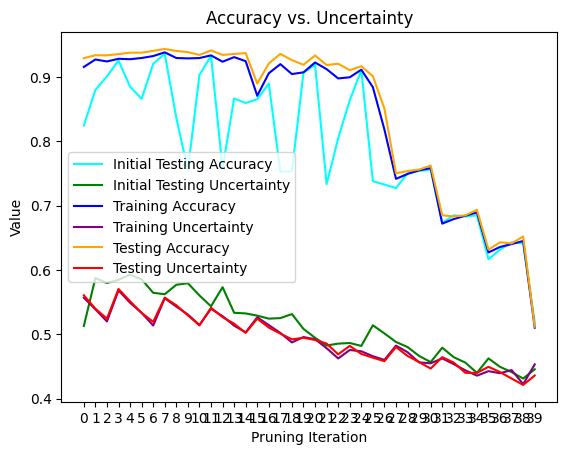

In [70]:
iterations = 10 * (len(model)-1)
modded_model = copy.deepcopy(model)
modded_optimizer = torch.optim.SGD(modded_model.parameters(), lr=0.01)
modded_optimizer.load_state_dict(optimizer.state_dict())

init_test_acc_vals = []
init_test_u_vals = []
train_acc_vals = []
train_u_vals = []
test_acc_vals = []
test_u_vals = []
param_count_vals = []

for iter in range(10):
    for i in range(len(model)-1):
        # scores = weight_sum(modded_model[i].weight)
        scores = svd_score(modded_model.activations[str(i)])
        # print("Layer {} scores: mean {:.3g}, std {:.3g}, min {:.3g}, smallest 25%:".format(i, scores.mean(), scores.std(), scores.min()), end=" ")
        to_prune = np.argsort(scores.detach().cpu().numpy())[:int(0.25*len(scores))]
        # print(to_prune)
        modded_model.prune(i, to_prune, optimizer=modded_optimizer, clear_activations=True)

    # print("The pruned model has {} effective parameters.".format(modded_model.parameter_count(masked = True)))
    # print("Validation after pruning: ", end = "")
        init_test_acc, init_test_u = test(modded_model, val_loader, criterion, return_vals=True)
        train_acc, train_u, test_acc, test_u = train(modded_model, train_loader, modded_optimizer, criterion, epochs=1, val_loader=val_loader, verbose=False, return_vals=True)

        init_test_acc_vals.append(init_test_acc)
        init_test_u_vals.append(init_test_u)
        train_acc_vals.append(train_acc)
        train_u_vals.append(train_u)
        test_acc_vals.append(test_acc)
        test_u_vals.append(test_u)
        print(f'Total Effective Parameters: {model.parameter_count(masked = True)}')

# Plotting the lines
plt.plot(np.arange(iterations), init_test_acc_vals, label='Initial Testing Accuracy', color='cyan')
plt.plot(np.arange(iterations), init_test_u_vals, label='Initial Testing Uncertainty', color='green')
plt.plot(np.arange(iterations), train_acc_vals, label='Training Accuracy', color='blue')
plt.plot(np.arange(iterations), train_u_vals, label='Training Uncertainty', color='purple')
plt.plot(np.arange(iterations), test_acc_vals, label='Testing Accuracy', color='orange')
plt.plot(np.arange(iterations), test_u_vals, label='Testing Uncertainty', color='red')
plt.xticks(np.arange(0, iterations, 1))

# Adding titles and labels
plt.title('Accuracy vs. Uncertainty')
plt.xlabel('Pruning Iteration')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

**NORTH:** Grow the model using a neurogenesis strategy similar to NORTH-Random.

Average loss: 0.0164, Accuracy: 5375/6000 (89.58%), Average Uncertainty: 0.3960
Train Epoch: 0 [0/54000 (0%)]	Loss: 0.724536	Uncertainty: 0.751241
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.688428	Uncertainty: 0.729685
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.635020	Uncertainty: 0.717458
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.631863	Uncertainty: 0.702276
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.603074	Uncertainty: 0.692650
Validation: Average loss: 0.0036, Accuracy: 5493/6000 (91.55%), Average Uncertainty: 0.6910
Total Effective Parameters: 15754
Average loss: 0.0036, Accuracy: 5493/6000 (91.55%), Average Uncertainty: 0.6910
Train Epoch: 0 [0/54000 (0%)]	Loss: 0.619479	Uncertainty: 0.687148
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.595671	Uncertainty: 0.680730
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.565700	Uncertainty: 0.669613
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.542399	Uncertainty: 0.664128
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.550965	Uncertainty: 0.653686
Vali

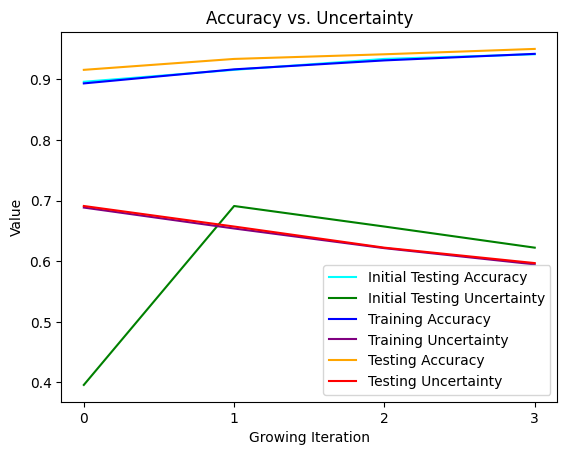

In [11]:
iterations = 1 * (len(model)-1)
modded_model_grow = copy.deepcopy(model)
modded_optimizer_grow = torch.optim.SGD(modded_model_grow.parameters(), lr=0.01)
modded_optimizer_grow.load_state_dict(optimizer.state_dict())

init_test_acc_vals = []
init_test_u_vals = []
train_acc_vals = []
train_u_vals = []
test_acc_vals = []
test_u_vals = []

for iter in range(1):
    for i in range(len(model)-1):
        # scores = svd_score(modded_model.activations[str(i)])
        max_rank = modded_model_grow[i].width()
        score = effective_rank(modded_model_grow.activations[str(i)])
        to_add = max(score-int(0.95*max_rank), 0)
        # print("Layer {} score: {}/{}, neurons to add: {}".format(i, score, max_rank, to_add))
        modded_model_grow.grow(i, to_add, fanin_weights="iterative_orthogonalization",
                               optimizer=modded_optimizer_grow)
    # print("The grown model now has {} effective parameters.".format(modded_model_grow.parameter_count(masked = True)))
    # print("Validation after growing: ", end = "")
        init_test_acc, init_test_u = test(modded_model_grow, val_loader, criterion, return_vals=True)
        train_acc, train_u, test_acc, test_u = train(modded_model_grow, train_loader, modded_optimizer_grow, criterion, epochs=1, val_loader=val_loader, return_vals=True)
        
        # for key in modded_model_grow.activations:
        #     print(modded_model_grow.activations[key].size())

        init_test_acc_vals.append(init_test_acc)
        init_test_u_vals.append(init_test_u)
        train_acc_vals.append(train_acc)
        train_u_vals.append(train_u)
        test_acc_vals.append(test_acc)
        test_u_vals.append(test_u)
        print(f'Total Effective Parameters: {model.parameter_count(masked = True)}')

# Plotting the lines
plt.plot(np.arange(iterations), init_test_acc_vals, label='Initial Testing Accuracy', color='cyan')
plt.plot(np.arange(iterations), init_test_u_vals, label='Initial Testing Uncertainty', color='green')
plt.plot(np.arange(iterations), train_acc_vals, label='Training Accuracy', color='blue')
plt.plot(np.arange(iterations), train_u_vals, label='Training Uncertainty', color='purple')
plt.plot(np.arange(iterations), test_acc_vals, label='Testing Accuracy', color='orange')
plt.plot(np.arange(iterations), test_u_vals, label='Testing Uncertainty', color='red')
plt.xticks(np.arange(0, iterations, 1))

# Adding titles and labels
plt.title('Accuracy vs. Uncertainty')
plt.xlabel('Growing Iteration')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

Average loss: 0.0164, Accuracy: 5375/6000 (89.58%), Average Uncertainty: 0.3960
Train Epoch: 0 [0/54000 (0%)]	Loss: 0.717804	Uncertainty: 0.754040
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.669807	Uncertainty: 0.727082
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.644049	Uncertainty: 0.715025
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.635917	Uncertainty: 0.703996
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.596844	Uncertainty: 0.691048
Validation: Average loss: 0.0036, Accuracy: 5492/6000 (91.53%), Average Uncertainty: 0.6912
Average loss: 0.0041, Accuracy: 5318/6000 (88.63%), Average Uncertainty: 0.7080
Train Epoch: 0 [0/54000 (0%)]	Loss: 0.616852	Uncertainty: 0.688535
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.586625	Uncertainty: 0.679779
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.568437	Uncertainty: 0.673817
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.559424	Uncertainty: 0.661130
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.555368	Uncertainty: 0.654133
Validation: Average loss: 0.0029, Accu

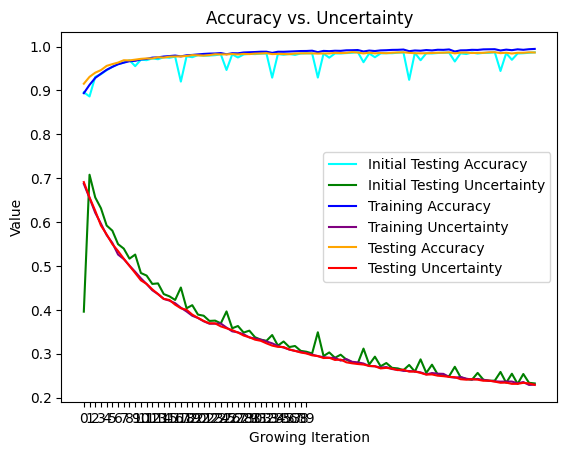

In [9]:
iterations = 10 * (len(model)-1)
modded_model_gp = copy.deepcopy(model)
modded_optimizer_gp = torch.optim.SGD(modded_model_gp.parameters(), lr=0.01)
modded_optimizer_gp.load_state_dict(optimizer.state_dict())

init_test_acc_vals = []
init_test_u_vals = []
train_acc_vals = []
train_u_vals = []
test_acc_vals = []
test_u_vals = []

for iter in range(10):
    for i in range(len(model)-1):
        
        
        max_rank = modded_model_gp[i].width()
        score = effective_rank(modded_model_gp.activations[str(i)])
        to_add = max(score-int(0.95*max_rank), 0)
        
        modded_model_gp.grow(i, to_add, fanin_weights="iterative_orthogonalization",
                            optimizer=modded_optimizer_gp)
    
        init_test_acc, init_test_u = test(modded_model_gp, val_loader, criterion, return_vals=True)
        train_acc, train_u, test_acc, test_u = train(modded_model_gp, train_loader, modded_optimizer_gp, criterion, epochs=1, val_loader=val_loader, return_vals=True)

        init_test_acc_vals.append(init_test_acc)
        init_test_u_vals.append(init_test_u)
        train_acc_vals.append(train_acc)
        train_u_vals.append(train_u)
        test_acc_vals.append(test_acc)
        test_u_vals.append(test_u)

        # for key in modded_model_gp.activations:
        #     print(modded_model_gp.activations[key].size())

        scores = svd_score(modded_model_gp.activations[str(i)])
        # print("Layer {} scores: mean {:.3g}, std {:.3g}, min {:.3g}, smallest 25%:".format(i, scores.mean(), scores.std(), scores.min()), end=" ")
        to_prune = np.argsort(scores.detach().cpu().numpy())[:to_add.item()]
        # print(to_prune)
        modded_model_gp.prune(i, to_prune, optimizer=modded_optimizer_gp, clear_activations=True)

        init_test_acc, init_test_u = test(modded_model_gp, val_loader, criterion, return_vals=True)
        train_acc, train_u, test_acc, test_u = train(modded_model_gp, train_loader, modded_optimizer_gp, criterion, epochs=1, val_loader=val_loader, return_vals=True)

        init_test_acc_vals.append(init_test_acc)
        init_test_u_vals.append(init_test_u)
        train_acc_vals.append(train_acc)
        train_u_vals.append(train_u)
        test_acc_vals.append(test_acc)
        test_u_vals.append(test_u)

        print(f'Total Effective Parameters: {model.parameter_count(masked = True)}')

# Plotting the lines
plt.plot(np.arange(iterations * 2), init_test_acc_vals, label='Initial Testing Accuracy', color='cyan')
plt.plot(np.arange(iterations * 2), init_test_u_vals, label='Initial Testing Uncertainty', color='green')
plt.plot(np.arange(iterations * 2), train_acc_vals, label='Training Accuracy', color='blue')
plt.plot(np.arange(iterations * 2), train_u_vals, label='Training Uncertainty', color='purple')
plt.plot(np.arange(iterations * 2), test_acc_vals, label='Testing Accuracy', color='orange')
plt.plot(np.arange(iterations * 2), test_u_vals, label='Testing Uncertainty', color='red')
plt.xticks(np.arange(0, iterations, 1))

# Adding titles and labels
plt.title('Accuracy vs. Uncertainty')
plt.xlabel('Growing Iteration')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()